# TP6 : Calibration d’un odomètre
### Auteurs : ARGUELLO Camilo et RAHAL Lamine

### Introduction

Dans ce TP, notre objectif c'est de faire des ajustements de données prises avec un dispositif de mesure de vistesse où on ne connaît pas les grandeurs physiques. Pour cela on va faire des estimations de valeurs attendues, en comparant avec des valeurs moyennes de vitesse connues pour différentes méthodes. Finalement, l'objectif c'est d'indiquer à quel point le dispositif de mesure est bien calibré en trouvant les valeurs des vitesses pour les jeux de données inconnues.

In [263]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import qexpy as q
import qexpy.plotting as qplt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import minimize, curve_fit
from IPython.display import display, Math

### 1. Ajustement d'histogrammes

On a un dataset avec des mesures de calibration d'un odomètre. Pour chacune des mesures on a une vitesse moyenne connue, à l'exception de la mesure `picinconnu`. 

Pour rendre le dataset plus facile à manipuler, on garde les données dans une liste `vitesses` qui contiennent les vitesses moyennes connues, et une liste `mesures` qui contient les mesures de l'odomètre.

In [238]:
# read the files pic1.csv, pic2.csv, pic3.csv
pic1 = pd.read_csv("pic1.csv", skiprows=0)
pic2 = pd.read_csv("pic2.csv", skiprows=0)
pic3 = pd.read_csv("pic3.csv", skiprows=0)
picinconnu = pd.read_csv("pic_inconnu.csv", skiprows=0)

vitesses = np.array([
    { 'pic': pic1, 'vitesse_moy': 13.9 }, # m/s
    { 'pic': pic2, 'vitesse_moy': 19.4 }, # m/s
    { 'pic': pic3, 'vitesse_moy': 36.1 }  # m/s
])

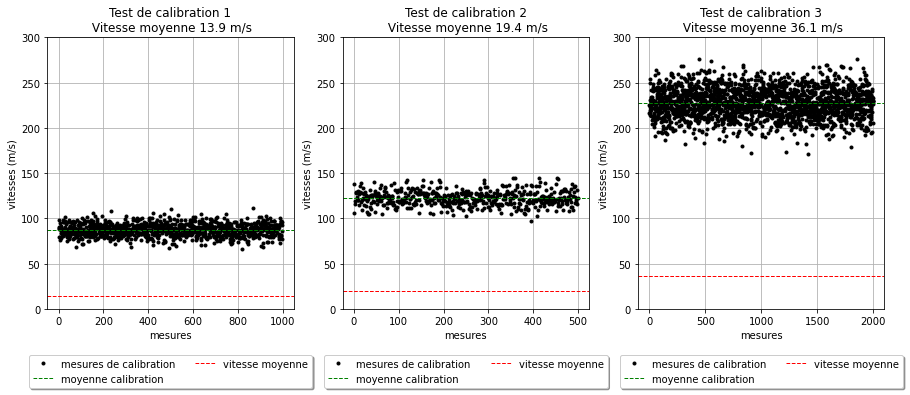

In [239]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, v in enumerate(vitesses):
    ax = axes[i]
    ax.plot(v["pic"]["mesures"], '.', color='black', label='mesures de calibration')
    # plot moyenne des mesures de calibration
    ax.axhline(np.mean(v["pic"]["mesures"]), color='g', linestyle='dashed', linewidth=1, label='moyenne calibration')
    # plot vitesses moyennes
    ax.axhline(v["vitesse_moy"], color='r', linestyle='dashed', linewidth=1, label='vitesse moyenne')
    ax.set_xlabel('mesures')
    ax.set_ylabel('vitesses (m/s)')
    ax.set_title('Test de calibration '+str(i+1)+'\n Vitesse moyenne ' + str(v["vitesse_moy"]) + ' m/s')
    ax.grid(True)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
    ax.set_ylim(0, 300) # on limite l'axe des y pour mieux voir les points
plt.show()

In [240]:
diff = [np.round(np.abs(v["vitesse_moy"] - np.mean(v["pic"]["mesures"])),2) for v in vitesses]
print("Différences entre la vitesse moyenne et la moyenne des mesures de calibration: ", diff)

Différences entre la vitesse moyenne et la moyenne des mesures de calibration:  [73.5, 103.02, 191.36]


Pour comprendre la structure des données, on fait un graphique qui vérifie de manière visuelle la distribution possible des données. Ceci est très utile pour pouvoir comprendre la dimension et le possible grandeur des données. Et plus tard vérifier à l'aide d'un histogramme. Cette observation montre que la différence entre la valeur moyenne et la valeur médiane de la vitesse est de `73.5` pour la calibration 1, de `103.02` pour la calibration 2 et de `191.36` pour la calibration 3. Il peut s'agir d'un premier indicateur de la qualité de la calibration du dispositif.

Nous validons l'information à l'aide d'un histogramme.

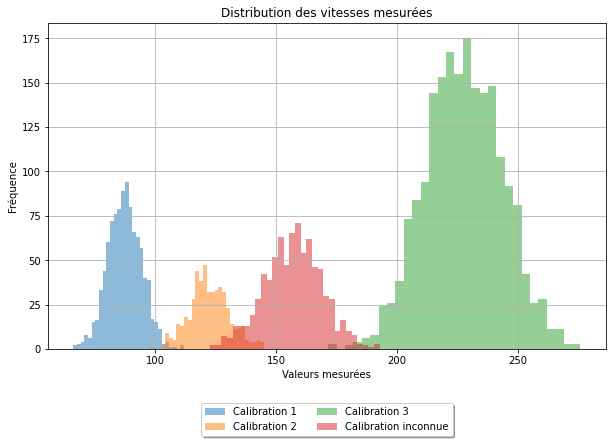

In [241]:
# Lecture des données à partir des fichiers CSV
pic1_data = pd.read_csv('pic1.csv')
pic2_data = pd.read_csv('pic2.csv')
pic3_data = pd.read_csv('pic3.csv')
pic_inconnu_data = pd.read_csv('pic_inconnu.csv')

# Extraction des valeurs de vitesse
pic1_speed = pic1_data['mesures']
pic2_speed = pic2_data['mesures']
pic3_speed = pic3_data['mesures']
pic_inconnu_speed = pic_inconnu_data['mesures']

# Tracé des histogrammes
plt.figure(figsize=(10, 6))
plt.hist(pic1_speed, bins=30, alpha=0.5, label='Calibration 1')
plt.hist(pic2_speed, bins=30, alpha=0.5, label='Calibration 2')
plt.hist(pic3_speed, bins=30, alpha=0.5, label='Calibration 3')
plt.hist(pic_inconnu_speed, bins=30, alpha=0.5, label='Calibration inconnue')

plt.xlabel('Valeurs mesurées')
plt.ylabel('Fréquence')
plt.title('Distribution des vitesses mesurées')
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.show()

Il s'agit de trois distributions **gaussiennes**. Les paramètres sont donc la moyenne (qui donne la position centrale de la distribution) et l'écart type (qui mesure la dispersion des données autour de la moyenne). Par exemple, la mesure de calibration 1 et calibration 2, visuellement, n'ont pas une grande dispersion, comparés aux mesures de calibration 3. Ces valeurs seront vérifiées dans la section suivante.

### 1.2 Estimation de la moyenne

Nous allons estimer les valeurs moyennes des mesures pour chaque pic, pour cela on va utiliser:

- Une méthode de mesure de la moyenne statistique
- Une méthode d'ajustement avec une minimisation numérique en utilisant `scipy.minimize`
- Une ajustement des données avec `QExPy`

#### Mesure de la moyenne statistique

Pour chaque ensemble des mesures, on calcule la moyenne et l'écart-type associé. L'objectif est d'en déduire une relation entre les mesures de l'odomètre et les vitesses moyennes.

In [242]:
# add pic inconnu to the array of vitesses
vitesses = np.append(vitesses, [{ 'pic': picinconnu, 'vitesse_moy': None }])

In [243]:
# Calcul de la moyenne et de l'écart-type pour chaque pic
pic1_mean = np.mean(pic1_speed)
pic1_std = np.std(pic1_speed)
pic2_mean = np.mean(pic2_speed)
pic2_std = np.std(pic2_speed)
pic3_mean = np.mean(pic3_speed)
pic3_std = np.std(pic3_speed)
pic_inconnu_mean = np.mean(pic_inconnu_speed)
pic_inconnu_std = np.std(pic_inconnu_speed)

moyennes_statistique = np.array([pic1_mean, pic2_mean, pic3_mean, pic_inconnu_mean])
ecart_types_statistique = np.array([pic1_std, pic2_std, pic3_std, pic_inconnu_std])

# Affichage des moyennes et des écart-types
print("Pic 1 - Moyenne : {:.2f}, Écart-type : {:.2f}".format(pic1_mean, pic1_std))
print("Pic 2 - Moyenne : {:.2f}, Écart-type : {:.2f}".format(pic2_mean, pic2_std))
print("Pic 3 - Moyenne : {:.2f}, Écart-type : {:.2f}".format(pic3_mean, pic3_std))
print("Pic inconnu - Moyenne : {:.2f}, Écart-type : {:.2f}".format(pic_inconnu_mean, pic_inconnu_std))

Pic 1 - Moyenne : 87.40, Écart-type : 6.88
Pic 2 - Moyenne : 122.42, Écart-type : 8.32
Pic 3 - Moyenne : 227.46, Écart-type : 15.95
Pic inconnu - Moyenne : 157.02, Écart-type : 11.86


Maintenant nouus allons calculer l'erreur sur les moyennes en utilisant la formule de l'erreur standard de la moyenne, qui est donnée par l'écart-type divisé par la racine carrée du nombre d'échantillons. Voici le code qui fait ça:

In [244]:
# Calcul de l'erreur sur les moyennes
pic1_error = pic1_std / np.sqrt(len(pic1_speed))
pic2_error = pic2_std / np.sqrt(len(pic2_speed))
pic3_error = pic3_std / np.sqrt(len(pic3_speed))
pic_inconnu_error = pic_inconnu_std / np.sqrt(len(pic_inconnu_speed))

# Affichage des erreurs sur les moyennes
print("Pic 1 - Erreur sur la moyenne : {:.2f}".format(pic1_error))
print("Pic 2 - Erreur sur la moyenne : {:.2f}".format(pic2_error))
print("Pic 3 - Erreur sur la moyenne : {:.2f}".format(pic3_error))
print("Pic inconnu - Erreur sur la moyenne : {:.2f}".format(pic_inconnu_error))

Pic 1 - Erreur sur la moyenne : 0.22
Pic 2 - Erreur sur la moyenne : 0.37
Pic 3 - Erreur sur la moyenne : 0.36
Pic inconnu - Erreur sur la moyenne : 0.42


Enfin, nous pouvons déterminer le pic ayant la moyenne avec l'erreur relative la plus faible.

In [245]:
# Calcul de l'erreur relative sur les moyennes
pic1_relative_error = np.abs(pic1_error / pic1_mean)
pic2_relative_error = np.abs(pic2_error / pic2_mean)
pic3_relative_error = np.abs(pic3_error / pic3_mean)
pic_inconnu_relative_error = np.abs(pic_inconnu_error / pic_inconnu_mean)

# Affichage des erreurs relatives sur les moyennes
print("Pic 1 - Erreur relative sur la moyenne : {:.2%}".format(pic1_relative_error))
print("Pic 2 - Erreur relative sur la moyenne : {:.2%}".format(pic2_relative_error))
print("Pic 3 - Erreur relative sur la moyenne : {:.2%}".format(pic3_relative_error))
print("Pic inconnu - Erreur relative sur la moyenne : {:.2%}".format(pic_inconnu_relative_error))

print('\n----------------------------\n')

print('Taille jeu de données pic1 :', len(pic1_speed), 'mesures')
print('Taille jeu de données pic2 :', len(pic2_speed), 'mesures')
print('Taille jeu de données pic3 :', len(pic3_speed), 'mesures')
print('Taille jeu de données pic_inconnu :', len(pic_inconnu_speed), 'mesures')

Pic 1 - Erreur relative sur la moyenne : 0.25%
Pic 2 - Erreur relative sur la moyenne : 0.30%
Pic 3 - Erreur relative sur la moyenne : 0.16%
Pic inconnu - Erreur relative sur la moyenne : 0.27%

----------------------------

Taille jeu de données pic1 : 1000 mesures
Taille jeu de données pic2 : 500 mesures
Taille jeu de données pic3 : 2000 mesures
Taille jeu de données pic_inconnu : 800 mesures


L'erreur statistique le plus faible est pour le pic 3 ($0.16\%$). Ceci, parce qu'il s'agit du pic avec le jeu de données le plus grand ($N=2000$ mesures).

#### Ajustement des données avec une minimisation numérique

D'après la prémière partie de l'expérience on a vu que les données sont distribuées de manière gaussienne, on peut faire un ajustement de données en utilisant une minimisation de vraisemblance. On aura comme fonction coût la somme des carrés des différences entre les données et la fonction gaussienne. On va minimiser cette fonction en utilisant `scipy.minimize` et trouver les meilleurs paramètres de moyenne, écart-type et amplitude.

On cherche à minimiser:

$$ \chi^2 = \sum_{i} \frac{(N_i - f(x_i; \vec{\theta}) \delta x )^2}{N_i} $$

Où pour une fonction gaussienne:

$$ f(x; \vec{\theta}) = \frac{1}{\sqrt{2\pi} \sigma} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right) $$


In [246]:
# create a gaussian function f(x; \theta)
def gaussian(x, amplitude, moyenne, ecart_type):
    amplitude = 1 / (ecart_type * np.sqrt(2 * np.pi))
    return amplitude * np.exp(-(x - moyenne)**2 / (2 * ecart_type**2))

def chi_carre(params):
    # sum N * gaussian(x; theta) / N 
    N, Delta_x, X = params
    return np.sum((N * gaussian(X,*params) * Delta_x ) / N)

In [247]:
results_minimize = list()
x_is = list()
n_is = list()
w_is = list()

for i, v in enumerate(vitesses):
    vitesse = np.array(v["pic"]["mesures"])
    n, bins, patches = plt.hist(vitesse, bins=30, density=True)
    plt.close()

    # Pour chaque bin on calcule le valeur n_i (la hauteur), x_i (valeur au milieu) et w_i (largeur)
    # (i+1 - i) / 2
    n_i = n
    x_i = (bins[1:] + bins[:-1]) / 2
    w_i = bins[1:] - bins[:-1]
    
    # Paramètres à minimiser
    args=(n_i, w_i, x_i)
    # Variables initiales
    x0=[np.min(vitesse), np.mean(vitesse), np.std(vitesse)]
    result_minimize = minimize(chi_carre, x0=x0)
    results_minimize.append(result_minimize.x)
    x_is.append(x_i)
    n_is.append(n_i)
    w_is.append(w_i)
    display(Math(r'\text{{Paramètres qui minimisent }} \chi^2 \, \text{{pour le pic}} \, {:} : A = {:.2f}, \, \mu = {:.2f}, \, \sigma = {:.2f}'.format(i+1,result_minimize.x[0], result_minimize.x[1], result_minimize.x[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

On peut remarquer que les valeurs $\mu$ sont égales à celles trouvées par la mesure de moyenne statistique. Pour vérifier la qualité de l'ajustement, on affiche les histogrammes et les courbes trouvées pour chaque pic.

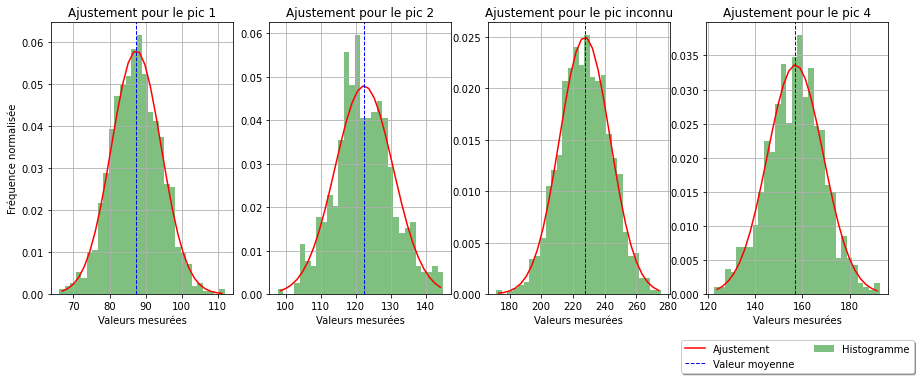

In [251]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i, result_minimize in enumerate(results_minimize):
    axes[i].bar(x_is[i], n_is[i], width=w_is[i], color='g', alpha=0.5, label='Histogramme')
    axes[i].plot(x_is[i], gaussian(x_is[i], *result_minimize), 'r-', label='Ajustement')
    axes[i].axvline(result_minimize[1], color='b', linestyle='dashed', linewidth=1, label='Valeur moyenne')
    axes[i].set_xlabel('Valeurs mesurées')
    if i == 2:
        axes[i].set_title('Ajustement pour le pic inconnu')
    else:
        axes[i].set_title('Ajustement pour le pic ' + str(i+1))
    axes[i].grid(True)

axes[0].set_ylabel('Fréquence normalisée')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.show()

#### Ajustement des données avec `QExPy`

De même, nous utiliserons `qexpy` pour ajuster les données expérimentales. On utilisera la méthode `fit` avec une paramètre de `GAUSSIAN` pour ajuster les données en suivant une distribution donnée. Cette méthode nous donnera les valeurs $\mu$ et $\sigma$ ainsi que les corrélations entre les paramètres.

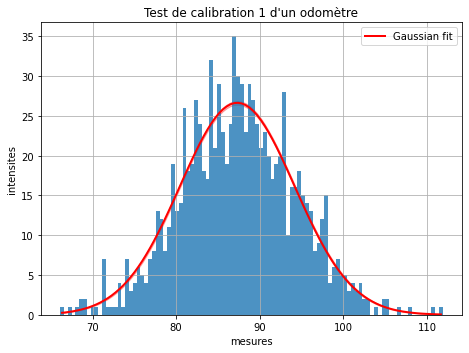

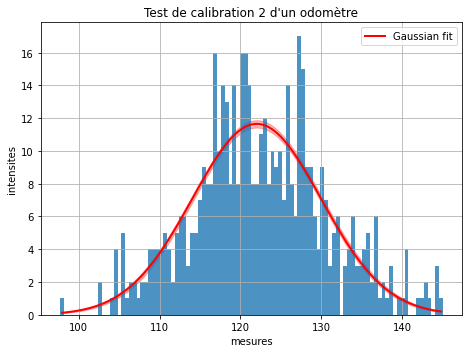

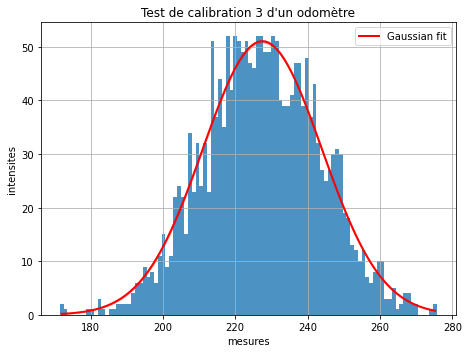

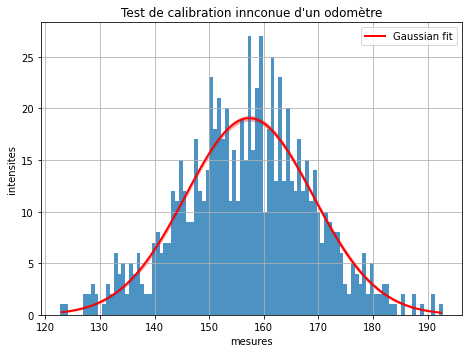

In [252]:
results_qexpy = list()

for i, v in enumerate(vitesses):
    vitesse = np.array(v["pic"]["mesures"])
    n, bins, figure = qplt.hist(vitesse, bins=100)
    result = figure.fit(model=q.FitModel.GAUSSIAN, parguess=[np.max(vitesse), np.mean(vitesse), np.std(vitesse)], color='r', label='Gaussian fit')
    results_qexpy.append(result)
    figure.legend()
    if v["vitesse_moy"] == None:
        figure.title = 'Test de calibration innconue d\'un odomètre'
    else:
        figure.title = 'Test de calibration '+ str(i+1) +' d\'un odomètre'
    figure.xname = 'mesures'
    figure.yname = 'intensites'
    figure.show()

In [253]:
# On récupère les paramètres des gaussiennes
# Les paramètres récupérés sont dans l'ordre: amplitude, moyenne, écart-type
params = [result.params for result in results_qexpy]
qexpy_values = [p.value for param in params for p in param]
qexpy_incertitudes = [p.error for param in params for p in param]

#reshape values to 4x3 matrix (4 gaussians, 3 parameters)
qexpy_values = np.reshape(qexpy_values, (4, 3))
moyennes_qexpy = qexpy_values[:,1]
ecart_types_qexpy = qexpy_values[:,2]

In [260]:
for i, result in enumerate(results_qexpy):
  params = result.params
  q_moyenne = params[1]
  q_ecart_type = params[2]
  display(Math(r'\text{{Paramètres trouvées avec QExPy }} \, \text{{pour le pic}} \, {:} : \, \mu = {:.2f} \pm \sigma = {:.2f} m/s'.format(i+1, q_moyenne.value, q_ecart_type.value)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [193]:
# On a une liste de résultats des moyennes pour chaque pic
# On montre par exemple le résultat pour le premier pic
print(results_qexpy[0])

----------------- Fit Results -------------------
Fit of histogram to gaussian

Result Parameter List: 
normalization = 557 +/- 7,
mean = 157.4 +/- 0.2,
std = 11.7 +/- 0.2

Correlation Matrix: 
[[ 1.000e+00 -1.560e-04  5.783e-01]
 [-1.560e-04  1.000e+00 -2.417e-04]
 [ 5.783e-01 -2.417e-04  1.000e+00]]

chi2/ndof = 0.00/96

--------------- End Fit Results -----------------


In [261]:
print(results_qexpy[1])

----------------- Fit Results -------------------
Fit of histogram to gaussian

Result Parameter List: 
normalization = 233 +/- 4,
mean = 122.0 +/- 0.2,
std = 8.0 +/- 0.2

Correlation Matrix: 
[[1.000e+00 4.532e-04 5.785e-01]
 [4.532e-04 1.000e+00 6.989e-04]
 [5.785e-01 6.989e-04 1.000e+00]]

chi2/ndof = 0.00/96

--------------- End Fit Results -----------------


En analysant les matrices de corrélation (où on a les paramères de normalisation, moyenne et écart-type) on remarque que les valeurs sont similaires pour chaque pic. En effet, par exemple pour la moyenne on obtient presque toujours la même, peu importe la taille du pic et la largeur. 

#### Comparaison des résultats

Dans cette partie nous cherchons à comparer les différentes méthodes d'analyses réalisées précédemment. Nous allons comparer la moyenne statistique trouvée, ainsi que les valeurs moyennes données en faisant un ajustement par `QexPy`. L'objectif est de voir et choisir la meilleur méthode pour s'approcher au mieux de la vraie valeur de la vitesse pour les mesures `pic_inconnu`.

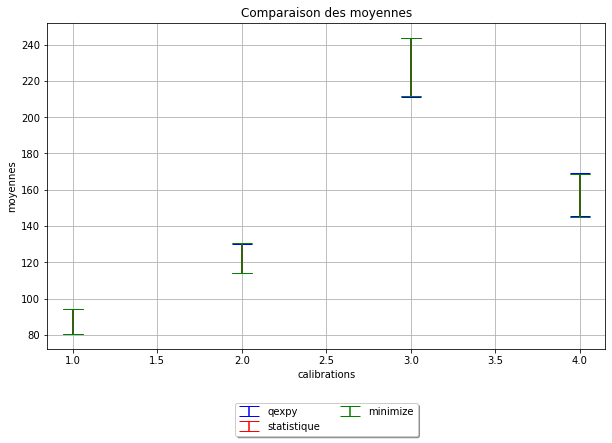

In [199]:
calibration = np.arange(1, 5) # 4 calibrations
# plot error bars
plt.figure(figsize=(10, 6))
plt.errorbar(calibration, moyennes_qexpy, yerr=ecart_types_qexpy, fmt = 'none', capsize = 10, ecolor = 'blue', label='qexpy')
plt.errorbar(calibration, moyennes_statistique, yerr=ecart_types_statistique, fmt = 'none', capsize = 10, ecolor = 'red', label='statistique')
plt.errorbar(calibration, np.array(results_minimize)[:,1], yerr=np.array(results_minimize)[:,2], fmt = 'none', capsize = 10, ecolor = 'green', label='minimize')
plt.xlabel('calibrations')
plt.ylabel('moyennes')
plt.title('Comparaison des moyennes')
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.show()

On observe que les valeurs sont similaires avec les 3 méthodes. La seule différence se porte sur les erreurs. Effectivement, voit tout de suite que la méthode qui a les plus grandes barres d'erreurs est l'ajustemet avec une minimisation numérique. 

Ensuite, les deux autres méthodes sont proches mais on voit quand même que celle qui minimise les erreurs est la méthode de l'ajustement par `QuexPy`. Nous prendrons donc ces valeurs moyennes pour trouver la meilleure valeur de calibration de l'odomètre.

#### 1.3 Détermination des paramètres de la calibration

Dans cette partie, nous cherchons à calibrer le détecteur pour pouvoir déduire la vitesse du pic inconnu en fonction de celle des autres. 

À l'aide de la fonction `LinearRegression()`, nous allons donc faire un ajustement linéaire sur les trois pics connus afin d'extraire la vitesse ainsi que l'erreur du pic inconnu.

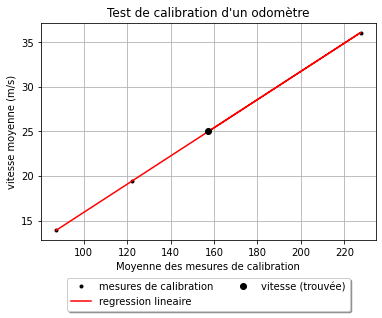

In [262]:
x = np.array([moyennes_qexpy[i] for i,v in enumerate(vitesses) if v['vitesse_moy'] is not None]).reshape(-1, 1)
y = np.array([v['vitesse_moy'] for v in vitesses if v['vitesse_moy'] is not None])

# Fit a linear regression model
model = LinearRegression()
model.fit(x, y)

# On récupère les paramètres des gaussiennes
# Ici x_pred correspond aux moyennes des gaussiennes et y_pred à la vitesse moyenne manquante
x_pred = np.array([moyennes_qexpy[i] for i,v in enumerate(vitesses)]).reshape(-1, 1)
y_pred = model.predict(x_pred)

a = model.coef_[0]
b = model.intercept_

plt.plot(x, y, '.', color='black', label='mesures de calibration')
plt.plot(x_pred, y_pred,  color='red', label='regression lineaire')

# add a point for the unknown speed
plt.plot(x_pred[3], y_pred[3], 'o', color='black', label='vitesse (trouvée)')

plt.xlabel('Moyenne des mesures de calibration')
plt.ylabel('vitesse moyenne (m/s)')
plt.title('Test de calibration d\'un odomètre')
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.show()


En observant ce graphe, on peut déduire d'une manière visuelle que la vitesse du pic inconnu est d'environ $25 \ m/s$.

#### 1.4 Calibration en `m/s` d'un pic
Il nous reste plus qu'à utiliser la calibration réalisée au-dessus pour afficher la vitesse du pic inconnu en km/h ainsi que son erreur.

On a ici une courbe de la forma $y = ax+b$ avec $a$ la pente et $b$ l'intérecept. $x$ la vitesse en $m/s$ et $y$ les valeurs moyennes .

On en deduit la formile

$$ \frac{y-b}{a} = x $$

On trouve la propagation pour la vitesse:

$$ \delta x = \sqrt{(\frac{\delta y}{a})^2 + (\frac{b \delta a}{a^2})^2 + (\delta b)^2} $$

In [222]:
# vitesse inconnue
vitesse_inconnue = y_pred[3] # m/s
vitesse_inconnue_km_h = vitesse_inconnue * 3.6 # km/h

# incertitude sur la vitesse inconnue
incertitude = np.sqrt(np.sum((y - model.predict(x))**2) / (len(x) - 2))
incertitude_km_h = incertitude * 3.6 # km/h

display(Math(r'\text{{Vitesse inconnue: }} {:.2f} \, \pm {:.4f} \, \text{{km/h}}'.format(vitesse_inconnue_km_h, incertitude_km_h)))

<IPython.core.display.Math object>

### Conclusion

Dans ce TP on a pu étudier les moyennes des pics avec différentes méthodes (statistique, ajustement numérique et qexpy). On a pu déduire une relation pour les mesures de l'instrument es les vitesses attendues. De même on a pu trouver la relation pour la calibration de l'odomètre qui nous donne la vitesse du pic inconnu $v=\frac{y-b}{a}$. La vitesse trouvée est de $89 km/h \pm 0.0038$ ce qui c'est cohérent avec la loi normale.